In [1]:
from shallowmind.src.model import ModelInterface
from shallowmind.src.data import DataInterface
from shallowmind.api.infer import prepare_inference
import pandas as pd
import torch
from tqdm import tqdm
import pickle
import pytorch_lightning as pl
pl.seed_everything(42)

# FuzzyTransformer
ckpt_path = '/projects/CIBCIGroup/00DataUploading/Liang/fuzzy_fnirs/Friends_fNIRS_Fuzzy/work_dir/AFTF-ds=PictureClass_l-d=1-nh=19-r=10-bs=128-ls=0.015-label=hand/ckpts/exp_name=AFTF-ds=PictureClass_l-d=1-nh=19-r=10-bs=128-ls=0.015-label=hand-cfg=FuzzyTramsformer_ALL_num_rules10_num_heads19_dataset_name=PictureClass_label=hand_base_lr=1.5e-2_depth=1_batch_size=128-bs=128-seed=42-val_f1_score=0.7414.ckpt'
config_path = '/projects/CIBCIGroup/00DataUploading/Liang/fuzzy_fnirs/Friends_fNIRS_Fuzzy/work_dir/AFTF-ds=PictureClass_l-d=1-nh=19-r=10-bs=128-ls=0.015-label=hand/FuzzyTramsformer_ALL_num_rules10_num_heads19_dataset_name=PictureClass_label=hand_base_lr=1.5e-2_depth=1_batch_size=128.py'

# # # Tramsformer
# ckpt_path = '/data/xiaowjia/Friends_fNIRS/work_dir/baseline_TFe-ds=PictureRating_t-d=3-nh=3-bs=128-ls=0.00015-label=hand/ckpts/exp_name=baseline_TFe-ds=PictureRating_t-d=3-nh=3-bs=128-ls=0.00015-label=hand-cfg=tramsformer_num_heads3_dataset_name=PictureRating_label=hand_base_lr=1.5e-4_depth=3_batch_size=128-bs=128-seed=42-val_f1_score=0.5905.ckpt'
# config_path = '/data/xiaowjia/Friends_fNIRS/work_dir/baseline_TFe-ds=PictureRating_t-d=3-nh=3-bs=128-ls=0.00015-label=hand/tramsformer_num_heads3_dataset_name=PictureRating_label=hand_base_lr=1.5e-4_depth=3_batch_size=128.py'

def config_function(config):
    config.data['train']['data_root'] = config.data['train']['data_root'].replace('/projects/CIBCIGroup/00DataUploading/Liang/fuzzy_fnirs/dataset', '/data/xiaowjia/Friends_fNIRS/data')
    config.data['val']['data_root'] = config.data['val']['data_root'].replace('/projects/CIBCIGroup/00DataUploading/Liang/fuzzy_fnirs/dataset', '/data/xiaowjia/Friends_fNIRS/data')
    config.data['test']['data_root'] = config.data['test']['data_root'].replace('/projects/CIBCIGroup/00DataUploading/Liang/fuzzy_fnirs/dataset', '/data/xiaowjia/Friends_fNIRS/data')

    config.data['train']['temp_save_folder'] = config.data['train']['temp_save_folder'].replace('/projects/CIBCIGroup/00DataUploading/Liang/fuzzy_fnirs/dataset', '/data/xiaowjia/Friends_fNIRS/data')
    config.data['val']['temp_save_folder'] = config.data['val']['temp_save_folder'].replace('/projects/CIBCIGroup/00DataUploading/Liang/fuzzy_fnirs/dataset', '/data/xiaowjia/Friends_fNIRS/data')
    config.data['test']['temp_save_folder'] = config.data['test']['temp_save_folder'].replace('/projects/CIBCIGroup/00DataUploading/Liang/fuzzy_fnirs/dataset', '/data/xiaowjia/Friends_fNIRS/data')

    config.model['return_attention_type'] = 'cross'
    config.model['type'] = config.model['type'].replace('FuzzyTransformer_arch','FuzzyTransformer_arch_explainable')
    return config

data_module, model = prepare_inference(config_path, ckpt_path, confing_function=config_function)
data_module.setup()
test_loader = data_module.test_dataloader()
data_table = test_loader.dataset.data_table
model = model.eval()

comet_ml is installed but `COMET_API_KEY` is not set.
Global seed set to 42


The pipeline is not setup, will use identity transform
The pipeline is not setup, will use identity transform
The pipeline is not setup, will use identity transform
The pipeline is not setup, will use identity transform


In [2]:
centers=model.model.encoder.decoder.layers[-1].self_attn.rules_keys
print(centers.shape)

torch.Size([11, 1, 3])


In [2]:
from tqdm import tqdm
device = torch.device('cuda:0')
model = model.to(device)
val_loader = data_module.val_dataloader()
data_table = val_loader.dataset.data_table
res = pd.DataFrame(columns=['pred', 'label'])
embs = []
atts = []
data_info = test_loader.dataset.data_index_table
for batch_idx, d in tqdm(enumerate(test_loader), total=len(test_loader)):
    torch.cuda.empty_cache()
    data = {'seq': d[0]['seq'].to(device),}
    label = d[1].to(device)
    with torch.no_grad():
        imgs = model.model.gen_data(data)
        latent,att = model.model.forward_encoder(imgs)
        latent = torch.cat([latent[:latent.shape[0]//2, :], latent[latent.shape[0]//2:, :]], dim=1)
        embs.append(latent.cpu().numpy())
        att = torch.stack([att[:att.shape[0]//2, :], att[att.shape[0]//2:, :]], dim=1)
        atts.append(att.cpu().numpy())
        latent = model.model.cls(latent)
        pred = latent.squeeze(1)
        pred = torch.argmax(pred, dim=1)
        pred = pred.cpu().numpy()
        label = label.cpu().numpy()
        res = pd.concat([res, pd.DataFrame({'pred': pred, 'label': label})], axis=0)

torch.cuda.empty_cache()

  0%|          | 0/64 [00:37<?, ?it/s]


ValueError: too many values to unpack (expected 2)

In [30]:
import numpy as np
data_info = data_info.reset_index(drop=True)
res = res.reset_index(drop=True)
res = pd.concat([data_info, res], axis=1)
embs = np.concatenate(embs, axis=0)
atts = np.concatenate(atts, axis=0)

In [25]:
atts.shape

(54578, 2, 3, 40, 40)

In [31]:
# Attention plot and explanation
import matplotlib.pyplot as plt
import seaborn as sns
ch_names = ['S1_D1 hbo', 'S1_D1 hbr', 'S1_D2 hbo', 'S1_D2 hbr', 'S2_D1 hbo', 'S2_D1 hbr', 'S2_D3 hbo', 'S2_D3 hbr', 'S3_D2 hbo', 'S3_D2 hbr', 'S3_D3 hbo', 'S3_D3 hbr', 'S3_D4 hbo', 'S3_D4 hbr', 'S4_D2 hbo', 'S4_D2 hbr', 'S4_D4 hbo', 'S4_D4 hbr', 'S4_D5 hbo', 'S4_D5 hbr', 'S5_D3 hbo', 'S5_D3 hbr', 'S5_D4 hbo', 'S5_D4 hbr', 'S5_D6 hbo', 'S5_D6 hbr', 'S6_D4 hbo', 'S6_D4 hbr', 'S6_D5 hbo', 'S6_D5 hbr', 'S6_D6 hbo', 'S6_D6 hbr', 'S7_D5 hbo', 'S7_D5 hbr', 'S7_D7 hbo', 'S7_D7 hbr', 'S8_D6 hbo', 'S8_D6 hbr', 'S8_D7 hbo', 'S8_D7 hbr']
# select the correct prediction
correct_res = res[res['pred'] == res['label']]
correct_res = correct_res.reset_index(drop=True)
correct_embs = embs[correct_res.index]
correct_atts = atts[correct_res.index].copy().mean(axis=2)

# statistics of the attention between different hand
import pingouin as pg
thres = 1e-8
mask_h_sub0 = np.zeros((len(ch_names), len(ch_names)))
mask_h_sub1 = np.zeros((len(ch_names), len(ch_names)))

for i in range(len(ch_names)):
    for j in range(len(ch_names)):
        res0 = pg.ttest(correct_atts[correct_res['hand'] == 1][:,0][:,i, j], correct_atts[correct_res['hand'] == 2][:,0][:,i, j])
        mask_h_sub0[i, j] = res0['p-val'] < thres
        res1 = pg.ttest(correct_atts[correct_res['hand'] == 1][:,1][:,i, j], correct_atts[correct_res['hand'] == 2][:,1][:,i, j])
        mask_h_sub1[i, j] = res1['p-val'] < thres

        


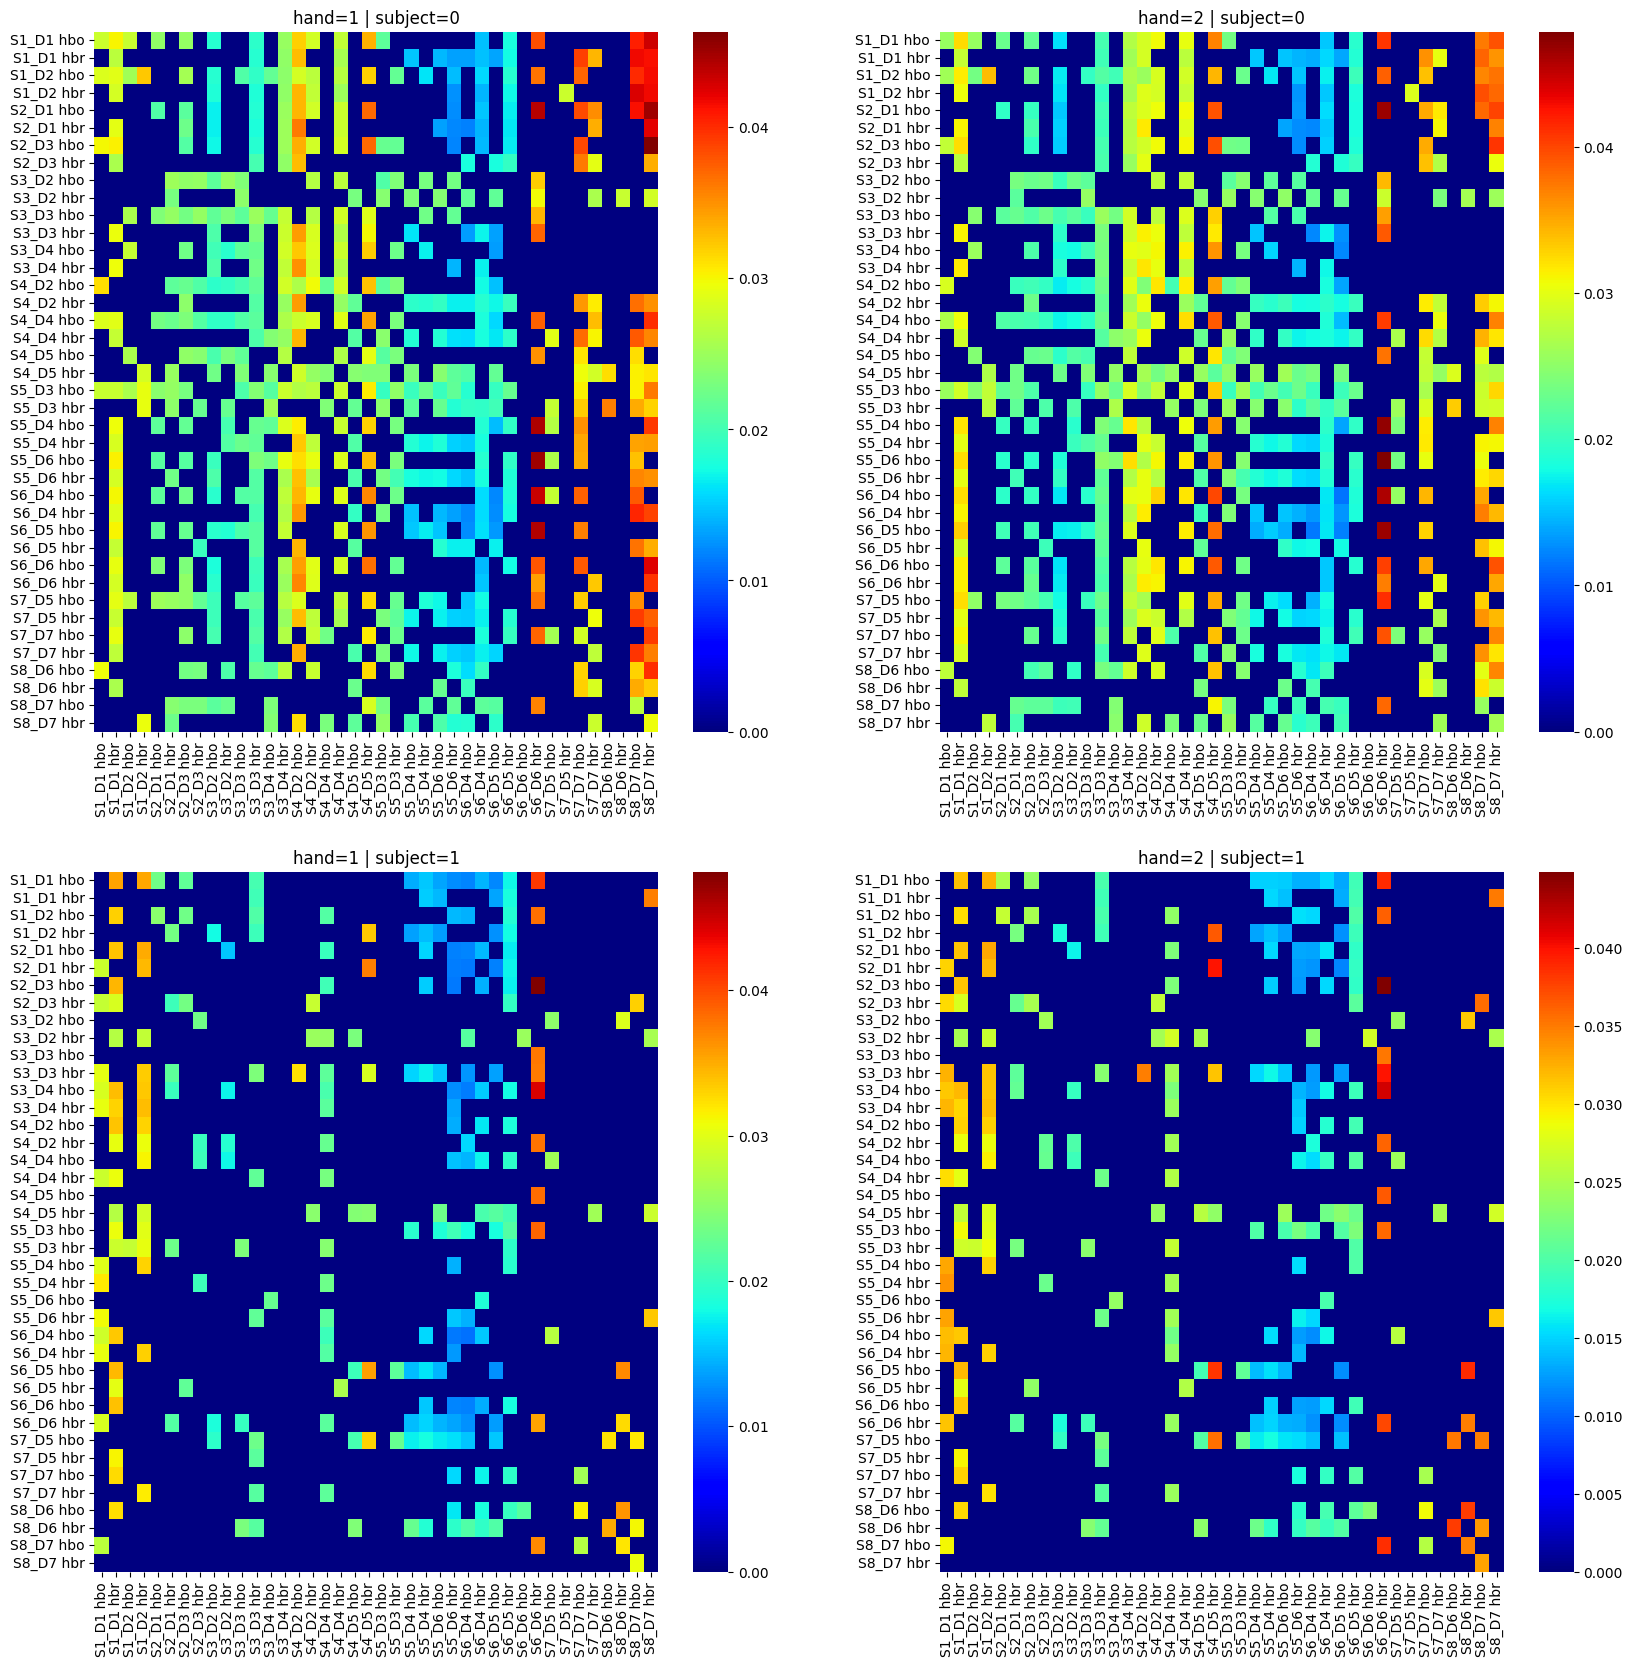

In [7]:
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(2, 2, 1)
sns.heatmap(correct_atts[correct_res['hand'] == 1][:,0].mean(0)*mask_h_sub0, ax=ax, xticklabels=ch_names, yticklabels=ch_names, cbar=True, cmap='jet')
plt.title('hand=1 | subject=0')
ax = fig.add_subplot(2, 2, 2)
sns.heatmap(correct_atts[correct_res['hand'] == 2][:,0].mean(0)*mask_h_sub0, ax=ax, xticklabels=ch_names, yticklabels=ch_names, cbar=True, cmap='jet')
plt.title('hand=2 | subject=0')
ax = fig.add_subplot(2, 2, 3)
sns.heatmap(correct_atts[correct_res['hand'] == 1][:,1].mean(0)*mask_h_sub1, ax=ax, xticklabels=ch_names, yticklabels=ch_names, cbar=True, cmap='jet')
plt.title('hand=1 | subject=1')
ax = fig.add_subplot(2, 2, 4)
sns.heatmap(correct_atts[correct_res['hand'] == 2][:,1].mean(0)*mask_h_sub1, ax=ax, xticklabels=ch_names, yticklabels=ch_names, cbar=True, cmap='jet')
plt.title('hand=2 | subject=1')
plt.show()

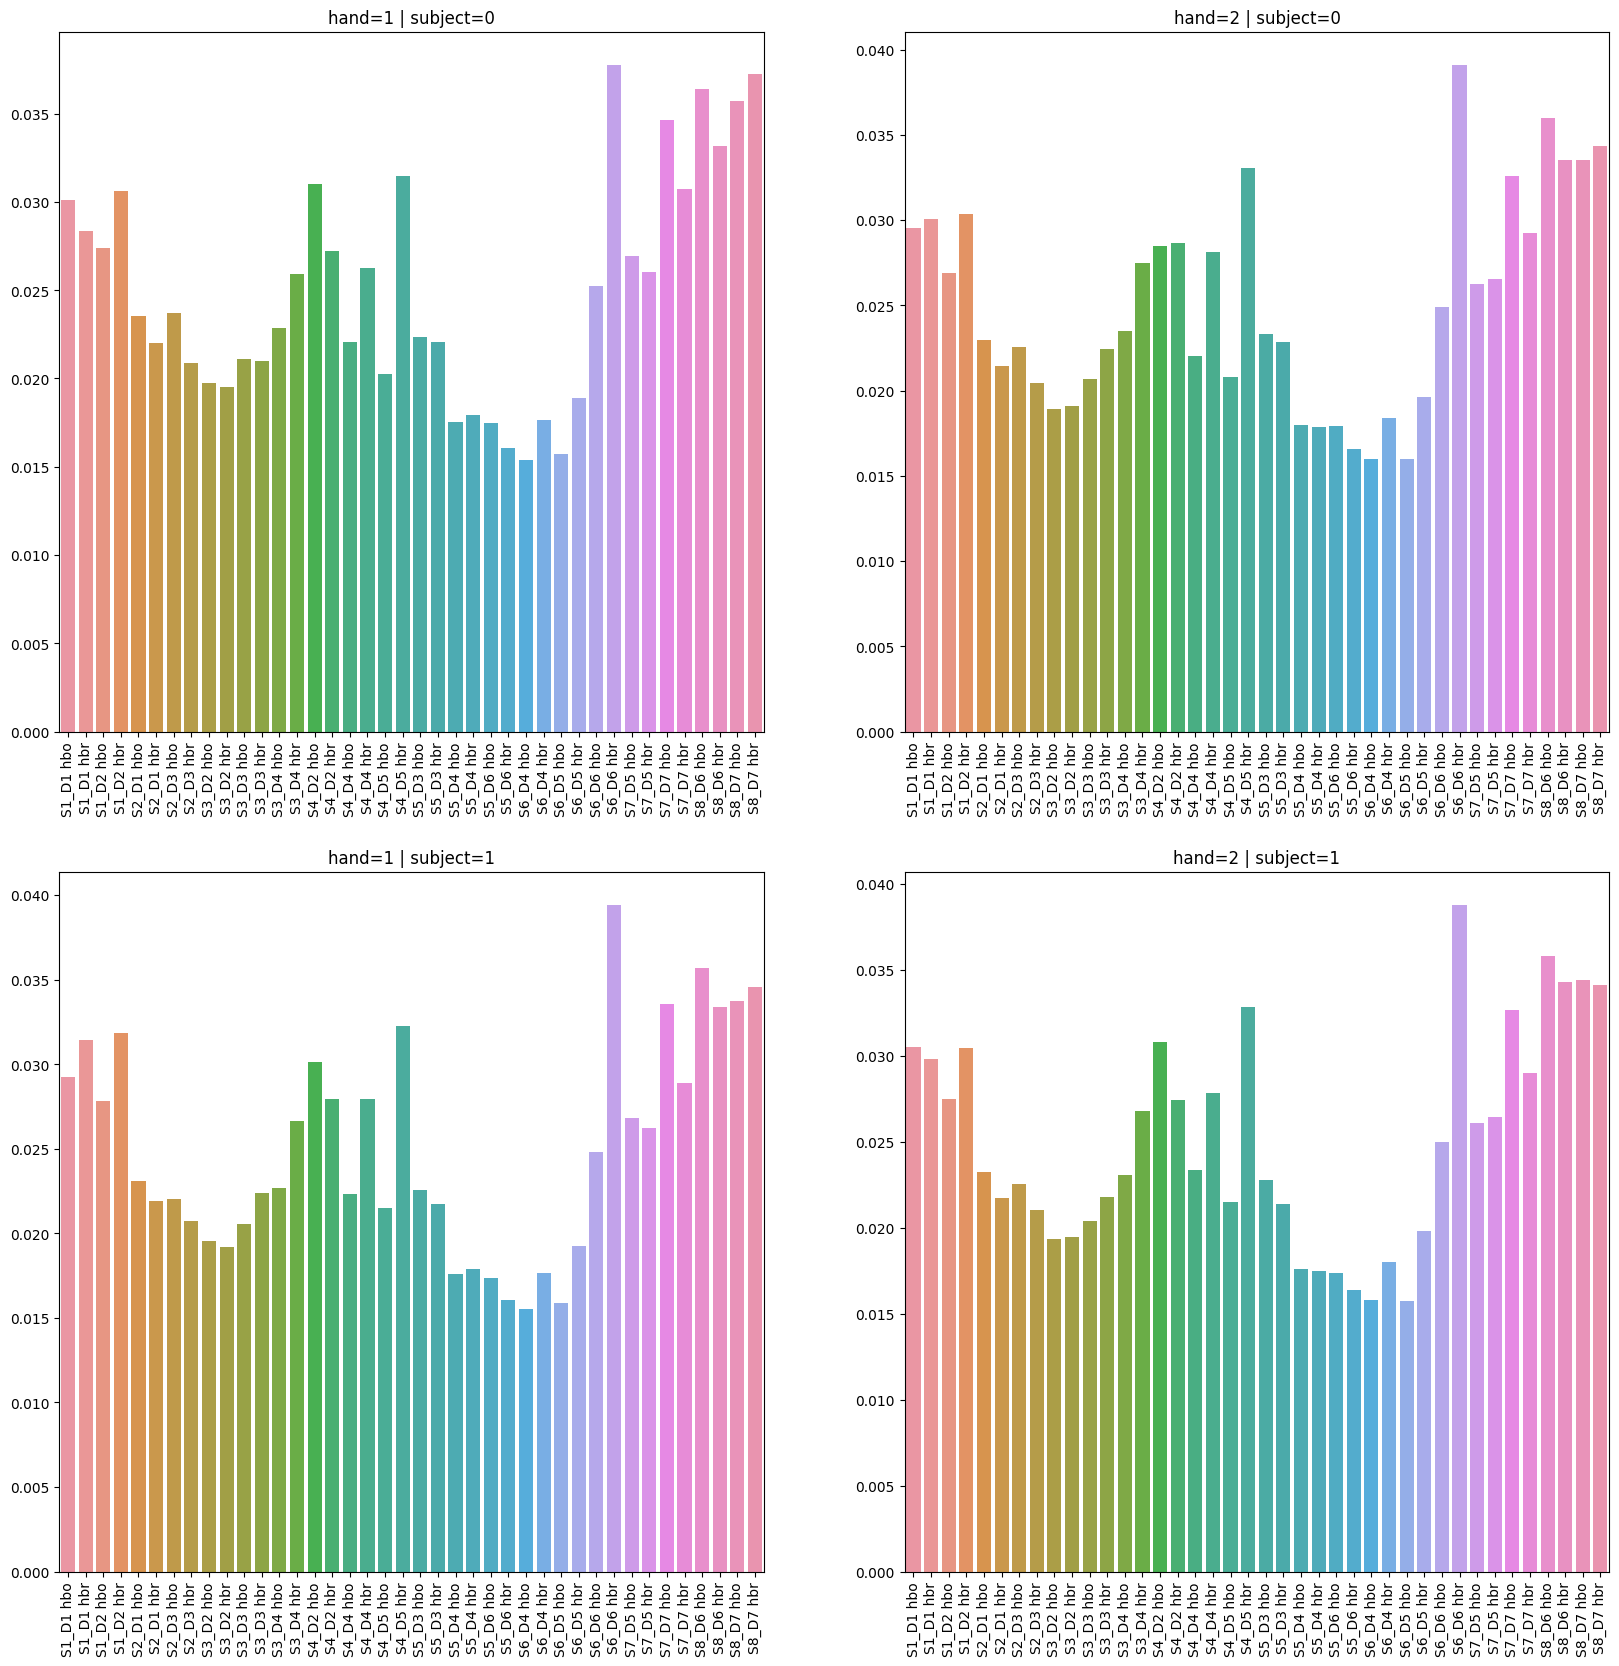

In [8]:
# average y axis
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(2, 2, 1)
sns.barplot(ax=ax, x=ch_names, y=(correct_atts[correct_res['hand'] == 1][:,0].mean(0)).mean(0))
plt.title('hand=1 | subject=0')
plt.xticks(rotation=90)
ax = fig.add_subplot(2, 2, 2)
sns.barplot(ax=ax, x=ch_names, y=(correct_atts[correct_res['hand'] == 2][:,0].mean(0)).mean(0))
plt.title('hand=2 | subject=0')
plt.xticks(rotation=90)
ax = fig.add_subplot(2, 2, 3)
sns.barplot(ax=ax, x=ch_names, y=(correct_atts[correct_res['hand'] == 1][:,1].mean(0)).mean(0))
plt.title('hand=1 | subject=1')
plt.xticks(rotation=90)
ax = fig.add_subplot(2, 2, 4)
sns.barplot(ax=ax, x=ch_names, y=(correct_atts[correct_res['hand'] == 2][:,1].mean(0)).mean(0))
plt.title('hand=2 | subject=1')
plt.xticks(rotation=90)
plt.show()

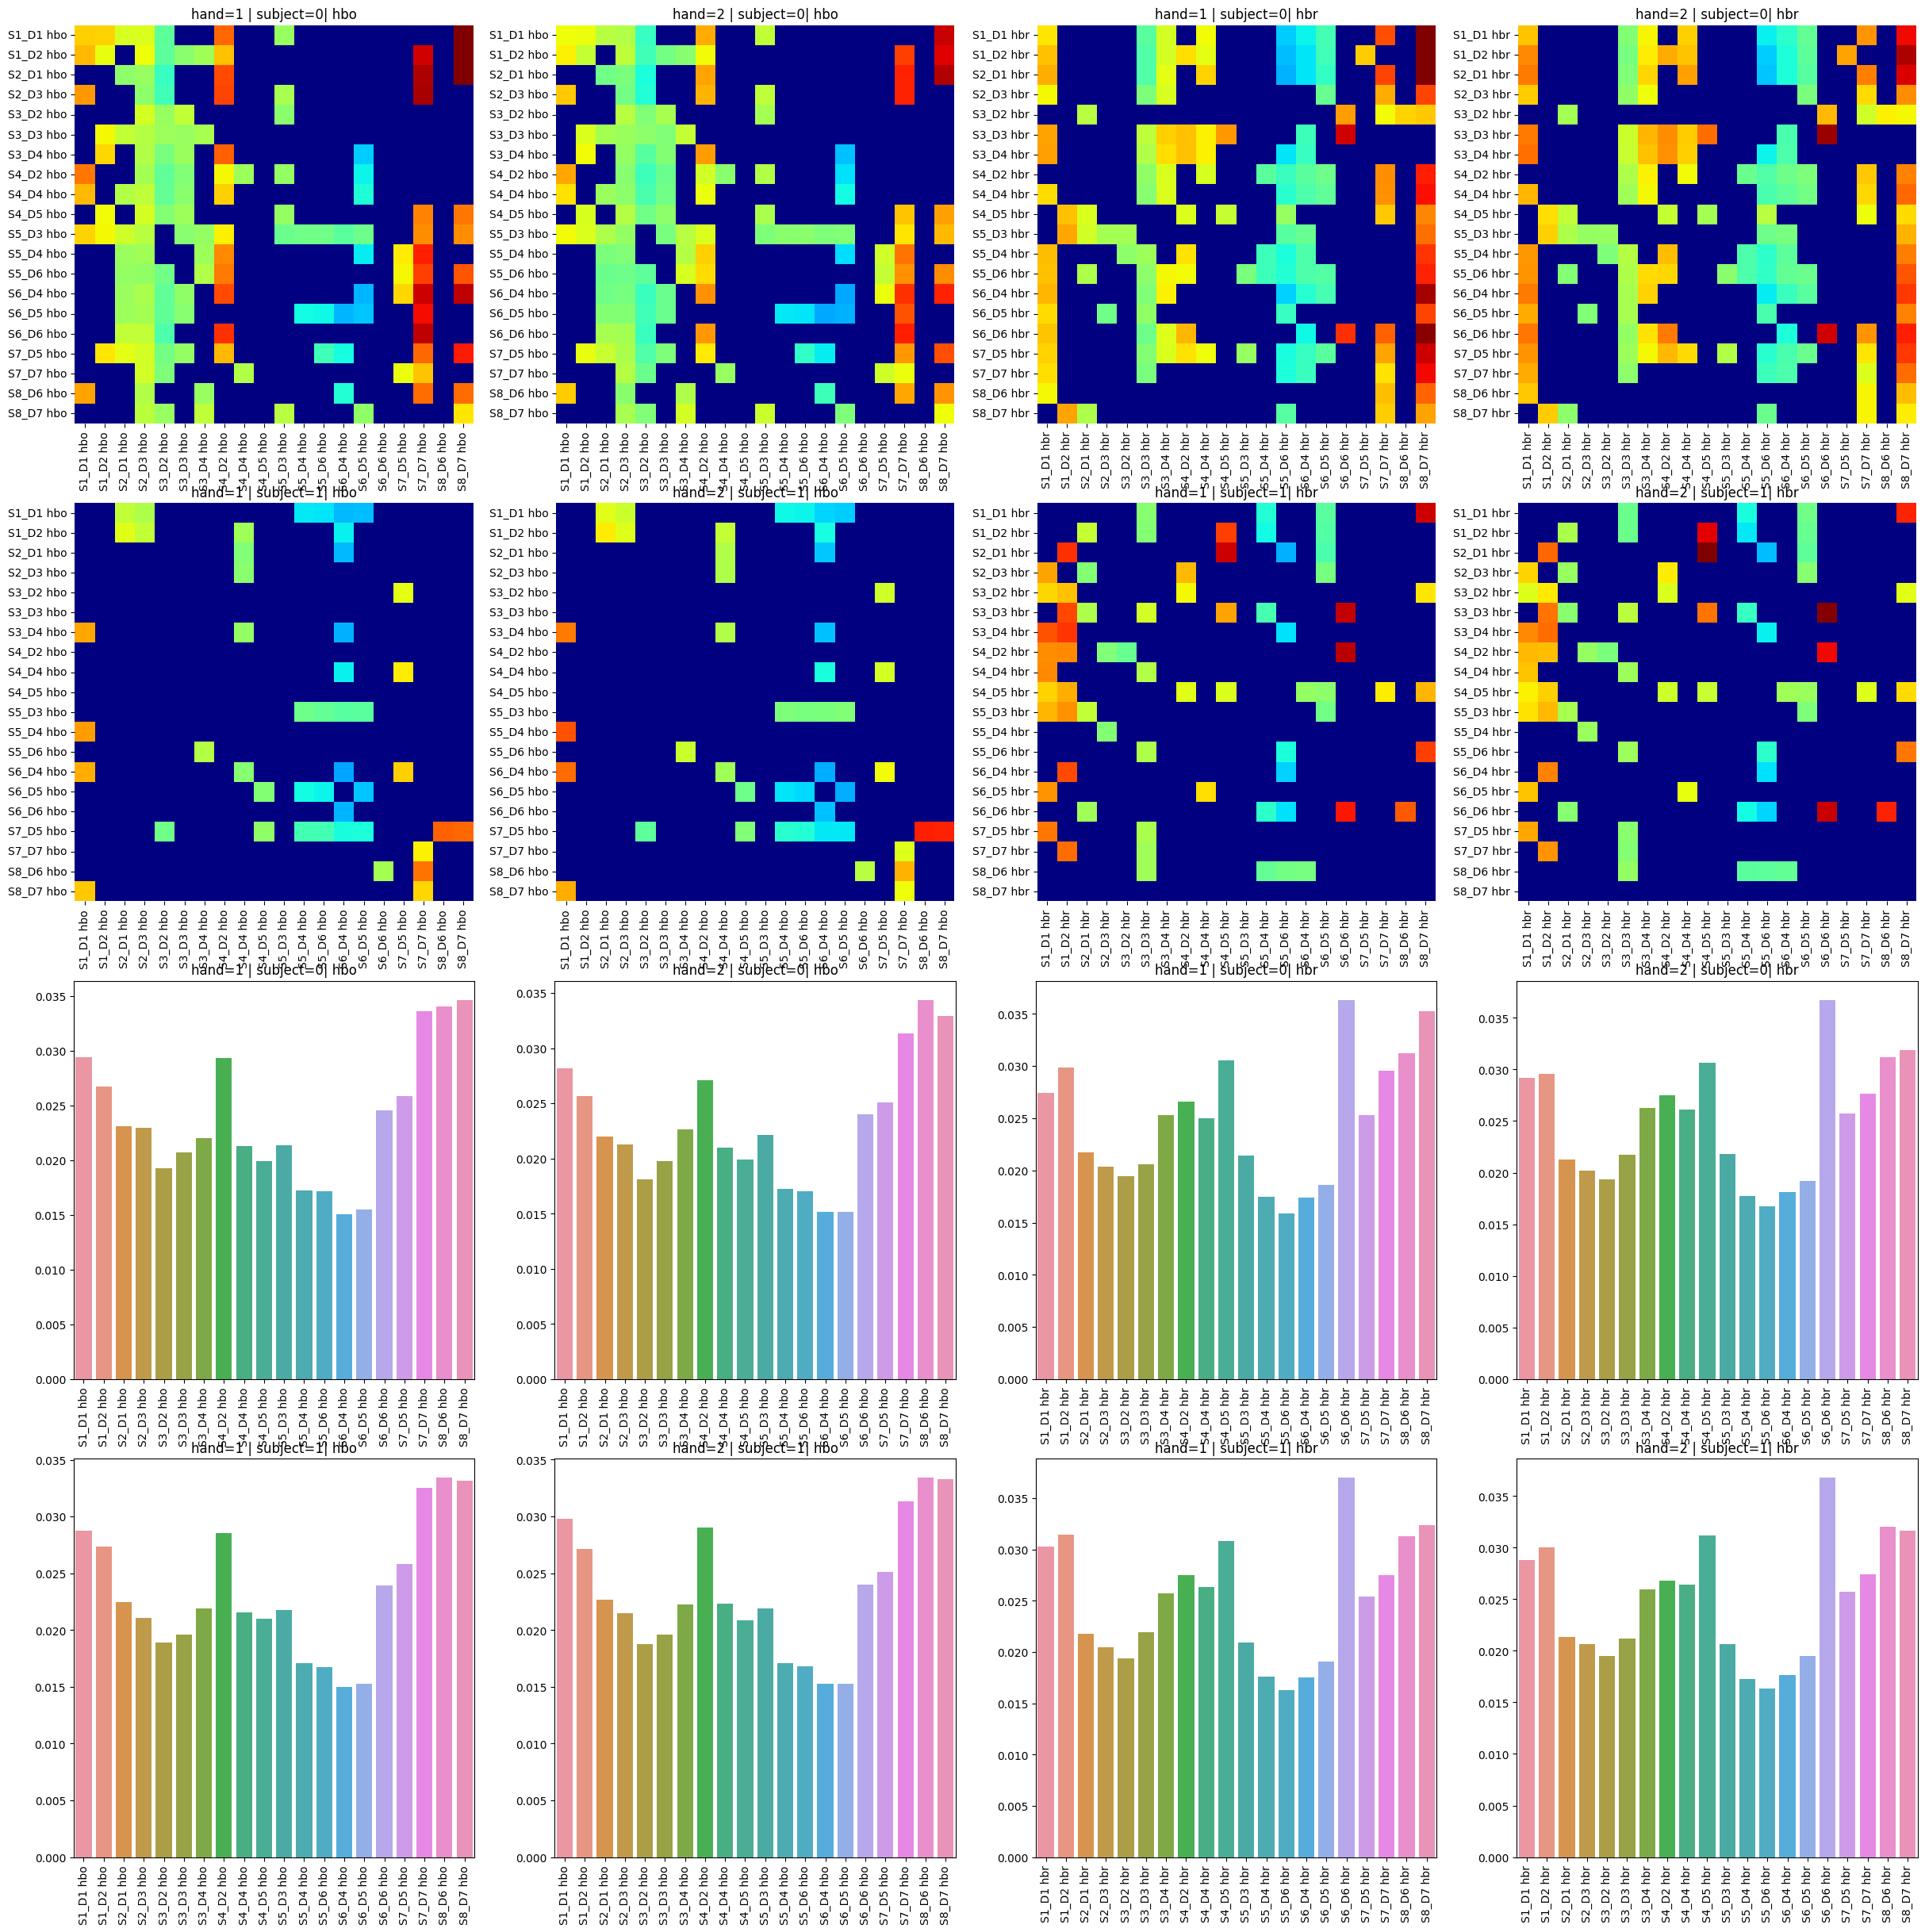

In [36]:
# Split the channel into HbO and HbR and plot again with ttest mask
hbr_channel_index = [i for i in range(len(ch_names)) if 'hbr' in ch_names[i]]
hbo_channel_index = [i for i in range(len(ch_names)) if 'hbo' in ch_names[i]]
fig = plt.figure(figsize=(30, 30))
vmin = 0
vmax = 0.04

ax = fig.add_subplot(4, 4, 1)
sns.heatmap(correct_atts[correct_res['hand'] == 1][:,0][:,hbo_channel_index,:][:,:,hbo_channel_index].mean(0)*mask_h_sub0[hbo_channel_index][:,hbo_channel_index], ax=ax, xticklabels=[ch_names[i] for i in hbo_channel_index], yticklabels=[ch_names[i] for i in hbo_channel_index], cbar=False, cmap='jet', square=True, vmin=vmin, vmax=vmax)
plt.title('hand=1 | subject=0| hbo')
ax = fig.add_subplot(4, 4, 2)
sns.heatmap(correct_atts[correct_res['hand'] == 2][:,0][:,hbo_channel_index,:][:,:,hbo_channel_index].mean(0)*mask_h_sub0[hbo_channel_index][:,hbo_channel_index], ax=ax, xticklabels=[ch_names[i] for i in hbo_channel_index], yticklabels=[ch_names[i] for i in hbo_channel_index], cbar=False, cmap='jet', square=True, vmin=vmin, vmax=vmax)
plt.title('hand=2 | subject=0| hbo')
ax = fig.add_subplot(4, 4, 3)
sns.heatmap(correct_atts[correct_res['hand'] == 1][:,0][:,hbr_channel_index,:][:,:,hbr_channel_index].mean(0)*mask_h_sub0[hbr_channel_index][:,hbr_channel_index], ax=ax, xticklabels=[ch_names[i] for i in hbr_channel_index], yticklabels=[ch_names[i] for i in hbr_channel_index], cbar=False, cmap='jet', square=True, vmin=vmin, vmax=vmax)
plt.title('hand=1 | subject=0| hbr')
ax = fig.add_subplot(4, 4, 4)
sns.heatmap(correct_atts[correct_res['hand'] == 2][:,0][:,hbr_channel_index,:][:,:,hbr_channel_index].mean(0)*mask_h_sub0[hbr_channel_index][:,hbr_channel_index], ax=ax, xticklabels=[ch_names[i] for i in hbr_channel_index], yticklabels=[ch_names[i] for i in hbr_channel_index], cbar=False, cmap='jet', square=True, vmin=vmin, vmax=vmax)
plt.title('hand=2 | subject=0| hbr')

ax = fig.add_subplot(4, 4, 5)
sns.heatmap(correct_atts[correct_res['hand'] == 1][:,1][:,hbo_channel_index,:][:,:,hbo_channel_index].mean(0)*mask_h_sub1[hbo_channel_index][:,hbo_channel_index], ax=ax, xticklabels=[ch_names[i] for i in hbo_channel_index], yticklabels=[ch_names[i] for i in hbo_channel_index], cbar=False, cmap='jet', square=True, vmin=vmin, vmax=vmax)
plt.title('hand=1 | subject=1| hbo')
ax = fig.add_subplot(4, 4, 6)
sns.heatmap(correct_atts[correct_res['hand'] == 2][:,1][:,hbo_channel_index,:][:,:,hbo_channel_index].mean(0)*mask_h_sub1[hbo_channel_index][:,hbo_channel_index], ax=ax, xticklabels=[ch_names[i] for i in hbo_channel_index], yticklabels=[ch_names[i] for i in hbo_channel_index], cbar=False, cmap='jet', square=True, vmin=vmin, vmax=vmax)
plt.title('hand=2 | subject=1| hbo')
ax = fig.add_subplot(4, 4, 7)
sns.heatmap(correct_atts[correct_res['hand'] == 1][:,1][:,hbr_channel_index,:][:,:,hbr_channel_index].mean(0)*mask_h_sub1[hbr_channel_index][:,hbr_channel_index], ax=ax, xticklabels=[ch_names[i] for i in hbr_channel_index], yticklabels=[ch_names[i] for i in hbr_channel_index], cbar=False, cmap='jet', square=True, vmin=vmin, vmax=vmax)
plt.title('hand=1 | subject=1| hbr')
ax = fig.add_subplot(4, 4, 8)
sns.heatmap(correct_atts[correct_res['hand'] == 2][:,1][:,hbr_channel_index,:][:,:,hbr_channel_index].mean(0)*mask_h_sub1[hbr_channel_index][:,hbr_channel_index], ax=ax, xticklabels=[ch_names[i] for i in hbr_channel_index], yticklabels=[ch_names[i] for i in hbr_channel_index], cbar=False, cmap='jet', square=True, vmin=vmin, vmax=vmax)
plt.title('hand=2 | subject=1| hbr')

ax = fig.add_subplot(4, 4, 9)
sns.barplot(ax=ax, x=[ch_names[i] for i in hbo_channel_index], y=(correct_atts[correct_res['hand'] == 1][:,0][:,hbo_channel_index,:][:,:,hbo_channel_index].mean(0)).mean(0))
plt.title('hand=1 | subject=0| hbo')
plt.xticks(rotation=90)
ax = fig.add_subplot(4, 4, 10)
sns.barplot(ax=ax, x=[ch_names[i] for i in hbo_channel_index], y=(correct_atts[correct_res['hand'] == 2][:,0][:,hbo_channel_index,:][:,:,hbo_channel_index].mean(0)).mean(0))
plt.title('hand=2 | subject=0| hbo')
plt.xticks(rotation=90)
ax = fig.add_subplot(4, 4, 11)
sns.barplot(ax=ax, x=[ch_names[i] for i in hbr_channel_index], y=(correct_atts[correct_res['hand'] == 1][:,0][:,hbr_channel_index,:][:,:,hbr_channel_index].mean(0)).mean(0))
plt.title('hand=1 | subject=0| hbr')
plt.xticks(rotation=90)
ax = fig.add_subplot(4, 4, 12)
sns.barplot(ax=ax, x=[ch_names[i] for i in hbr_channel_index], y=(correct_atts[correct_res['hand'] == 2][:,0][:,hbr_channel_index,:][:,:,hbr_channel_index].mean(0)).mean(0))
plt.title('hand=2 | subject=0| hbr')
plt.xticks(rotation=90)

ax = fig.add_subplot(4, 4, 13)
sns.barplot(ax=ax, x=[ch_names[i] for i in hbo_channel_index], y=(correct_atts[correct_res['hand'] == 1][:,1][:,hbo_channel_index,:][:,:,hbo_channel_index].mean(0)).mean(0))
plt.title('hand=1 | subject=1| hbo')
plt.xticks(rotation=90)
ax = fig.add_subplot(4, 4, 14)
sns.barplot(ax=ax, x=[ch_names[i] for i in hbo_channel_index], y=(correct_atts[correct_res['hand'] == 2][:,1][:,hbo_channel_index,:][:,:,hbo_channel_index].mean(0)).mean(0))
plt.title('hand=2 | subject=1| hbo')
plt.xticks(rotation=90)
ax = fig.add_subplot(4, 4, 15)
sns.barplot(ax=ax, x=[ch_names[i] for i in hbr_channel_index], y=(correct_atts[correct_res['hand'] == 1][:,1][:,hbr_channel_index,:][:,:,hbr_channel_index].mean(0)).mean(0))
plt.title('hand=1 | subject=1| hbr')
plt.xticks(rotation=90)
ax = fig.add_subplot(4, 4, 16)
sns.barplot(ax=ax, x=[ch_names[i] for i in hbr_channel_index], y=(correct_atts[correct_res['hand'] == 2][:,1][:,hbr_channel_index,:][:,:,hbr_channel_index].mean(0)).mean(0))
plt.title('hand=2 | subject=1| hbr')
plt.xticks(rotation=90)

plt.show()




In [ ]:
# Embedding visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from minepy import MINE
mine = MINE(alpha=0.6, c=15, est="mic_approx")

def distance(emb, metric='euclidean'):
    x = emb[emb.shape[0]//2:]
    y = emb[:emb.shape[0]//2]
    # normalize
    x = x/np.linalg.norm(x)
    y = y/np.linalg.norm(y)

    if metric == 'euclidean':
        return np.sqrt(np.sum((x-y)**2))
    elif metric == 'cosine':
        return 1 - np.abs(np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y)))
    elif metric == 'manhattan':
        return np.sum(np.abs(x-y))
    elif metric == 'corr':
        return 1-np.corrcoef(x,y)[0,1]
    elif metric == 'mi':
        mine.compute_score(x,y)
        return  mine.mic()

metric = 'cosine'
emb_dict = [distance(embs[i],metric = metric) for i in range(len(embs))]

# compare the distance between relationship and hand
res['emb'] = emb_dict

plt.figure(figsize=(9,3))
ax = plt.subplot(1,3,1)
sns.boxplot(x='hand', y='emb', hue='relationship_label', data=res.loc[res['emotion_label']==2], ax=ax)
plt.title(f'Emotion:Negtive')
ax.set_xlabel('Hand')
ax.set_ylabel('Distance')
ax = plt.subplot(1,3,2)
sns.boxplot(x='hand', y='emb', hue='relationship_label', data=res.loc[res['emotion_label']==3], ax=ax)
plt.title(f'Emotion:Neutral')
ax.set_xlabel('Hand')
ax.set_ylabel('Distance')
ax = plt.subplot(1,3,3)
sns.boxplot(x='relationship_label', y='emb', data=res, ax=ax)
plt.title(f'All Emotions')
ax.set_xlabel('Relationship')
ax.set_ylabel('Distance')
plt.tight_layout()
plt.show()

In [ ]:
res.to_csv('res_relationship_d=2-fuzzytransformer-cosine.csv', index=False)

In [ ]:
import pingouin as pg
res['subj'] = res['pair_idx'].apply(lambda x: ''.join(x.split('-')[1:]))
print('T-test: Relationship',pg.ttest(res.loc[res['relationship_label']==1, 'emb'], res.loc[res['relationship_label']==0, 'emb'], paired=False))
print('ANOVA')
print(pg.mixed_anova(dv='emb', within='hand', between='relationship_label', subject='subj', data=res))

In [ ]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import os
save_dir = '../output'
os.makedirs(save_dir, exist_ok=True)
# umap
print(embs.shape)
for seed in range(100):
    for n_c in range(2,21):
        for n_n in range(5, 51, 5):
            reducer = umap.UMAP(random_state=1,n_components=n_c, n_neighbors=n_n)
            embedding = reducer.fit_transform(embs)
            plt.figure(figsize=(3,3))
            plt.scatter(embedding[:, 0], embedding[:, 1], c=res['emotion_label'].values, cmap='Spectral', s=1)
            plt.gca().set_aspect('equal', 'datalim')
            plt.savefig(f'{save_dir}/umap_{n_c}_{n_n}.png')
            plt.close()




In [ ]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=res['relationship_label'].values, cmap='Spectral', s=1)
